<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Image Display and Manipulation</b> <br>
Contact authors: Alex Drlica-Wagner, Jeff Carlin <br>
Last verified to run: 2024-05-01 <br>
LSST Science Pipelines version: Weekly 2024_16 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

**Description:** Learn to display and manipulate images using the LSST Science Pipelines.

**Skills:** Display and manipulate images, explore image mask planes, create cutouts and RGB images.

**LSST Data Products:** Butler calexp and deepCoadd images, coadd objectTable

**Packages:** lsst.afw.display, lsst.daf.butler, lsst.geom, lsst.afw.image

**Credit:** This tutorial is based on the [`AFW_Display_Demo.ipynb`](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Visualization/AFW_Display_Demo.ipynb) notebook originally written by Brant Robertson and maintained by the LSST Stack Club.

More examples of the use of `lsst.afw.display` can be found in the [LSST Science Pipelines documentation](https://pipelines.lsst.io/getting-started/display.html).

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial is designed to help users get a brief feel for the `lsst.afw.display` library that enables the visual inspection of image data. The [`lsst.afw` library](https://github.com/lsst/afw) provides an "Astronomical Framework" (afw) while the `lsst.daf.*` libraries (see, e.g., [daf_base](https://github.com/lsst/daf_base)) provide a "Data Access Framework" (daf). Both libraries are used in this tutorial, with the `lsst.daf.butler` library used to access image data and the `lsst.afw.display` library used to show the exposure image on the screen using the matplotlib backend.

### 1.1. Package imports

Below, the `matplotlib.pyplot` sublibrary is imported for plotting, and the [`astropy.wcs`](https://docs.astropy.org/en/stable/wcs/index.html) package is imported for dealing with World Coordinate Systems (WCS).
The [`matplotlib`](https://matplotlib.org/) and [`astropy`](http://www.astropy.org/) libraries are widely used Python libraries for plotting, scientific computing, and astronomical data analysis.
The `gc` (garbage collector) package is imported to help clear the memory of large plots.

The `lsst.afw.display` and `lsst.afw.image` modules are loaded to gain access to the image visualization routines we'd like to use, and the `lsst.daf.butler` and `lsst.rsp.get_tap_service` modules are used to access data products.
The `lsst.geom` package is used for dealing with sky coordinates.

In [1]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler #butler is used for the image retrieval
from lsst.rsp import get_tap_service
import lsst.geom as geom

### 1.2. Define functions and parameters

#### 1.2.1. Functions

Matplotlib stores the data array associated with an image that is plotted. Since the LSST Charge-Coupled Device (CCD) detector images are large (~4k x 4k pixels), this can eventually lead to a memory overflow, which will cause the notebook kernel to die. To mitigate this issue, we define a function to clean up after we plot them.

In [2]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

<a id="cutout_coadd"></a>

Next we define a function to produce a cutout image from a coadd at the user-provided ra, dec.

In [3]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

The following function makes cutouts from `calexp` images instead of `deepCoadd` images.

In [4]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

<a id="create_rgb"></a>

Below we define a function that we will use to produce a color (RGB) image from a set of input images taken with three different filters. We'll use a tool from Astropy (`make_lupton_rgb`) that helps create RGB images (see [this Astropy guide to creating RGB images](https://docs.astropy.org/en/stable/visualization/rgb.html?highlight=make_lupton_rgb) for more info), and make a convenience function to combine the steps of making an RGB image. (This function was originally written by Aaron Watkins and Nushkia Chamba for their [Stack Club Course](https://github.com/LSSTScienceCollaborations/StackClubCourse) project exploring surface photometry in the LSST Science Pipelines.)

In [5]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

#### 1.2.2. Paramters

Let `afwDisplay` know that we want it to use `matplotlib` as our default display backend by setting the `setDefaultBackend()` function.

Remember that we made an alias to `lsst.afw.display` called `afwDisplay`, so we'll use that to call `setDefaultBackend()`.

In [6]:
afwDisplay.setDefaultBackend('matplotlib')

Set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other parameters to make the default plot style be color-blind friendly and otherwise make plots look nice.

In [7]:
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [8]:
params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

## 2. Load the data to visualize

To display an image, we must first load some data. The DP0.2 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2) that have been reprocessed by the LSST Project using a more recent version of the LSST Science Pipelines. To access these data, we instantiate a Butler directing it to the `dp02` data repository configuration and the `2.2i/runs/DP0.2` collection.  For more information on the `Butler`, see [lsst.daf.butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) and subsequent tutorials in this series.

In [9]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2') 

With a `Butler` instance generated, we can retrieve the desired calibrated exposure by telling the butler which visit and CCD ("detector") we wish to view. To do this, we define a dictionary with the required information. In this case, we access a single image from a specific visit (`192350`) and detector (`175`).

In [10]:
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'} #specifying the specific calexp image we want
#note that each single visit is only taken in one band, so for a calexp image the band parameter isn't actually necessary

In [11]:
calexp = butler.get('calexp', **dataId) #calexp files are individual exposure shots that later go into the coadded images

The `calexp` that is returned by the Butler in the previous cell is an `ExposureF` Python object. Exposures are powerful representations of image data because they contain not only the image data, but also a variance image for uncertainty propagation, a bit mask image, and key-value metadata. In the next section, we will use AFWDisplay to visualize the image and mask associated with this Exposure. More documentation on accessing and visualizing an Exposure be found [here](https://pipelines.lsst.io/getting-started/display.html).

## 3. Basic image visualization

### 3.1. Use AFWDisplay to visualize the image

We are now set to display the image. To do this, we:

1. Create a `matplotlib.pyplot` figure using `plt.figure()` -- this will be familiar to anyone with experience using `matplotlib`.
2. Create an alias to the `lsst.afw.display.Display` method that will allow us to display the data to the screen.  This alias will be called `display`.
3. Before showing the data on the screen, we have to decide how to apply an image stretch given the data. The algorithm we'll use is `asinh` -- familiar from SDSS images -- with a range of values set by `zscale`. To do this, we use the `scale()` function provided by `lsst.afw.display`. See the `scale()` function definition in the [`interface.py` file of the lsst.afw.display library](https://github.com/lsst/afw/blob/master/python/lsst/afw/display/interface.py).
4. Finally, we can display the image. To do this, we provide the `mtv()` method the `calexp.image` member of our calibrated image retrieved by the `butler`. We can then use `plt.show()` to display our figure.
5. After we are done creating and displaying the image, we remove the underlying data from memory.

All these tasks are best done within the same notebook cell.

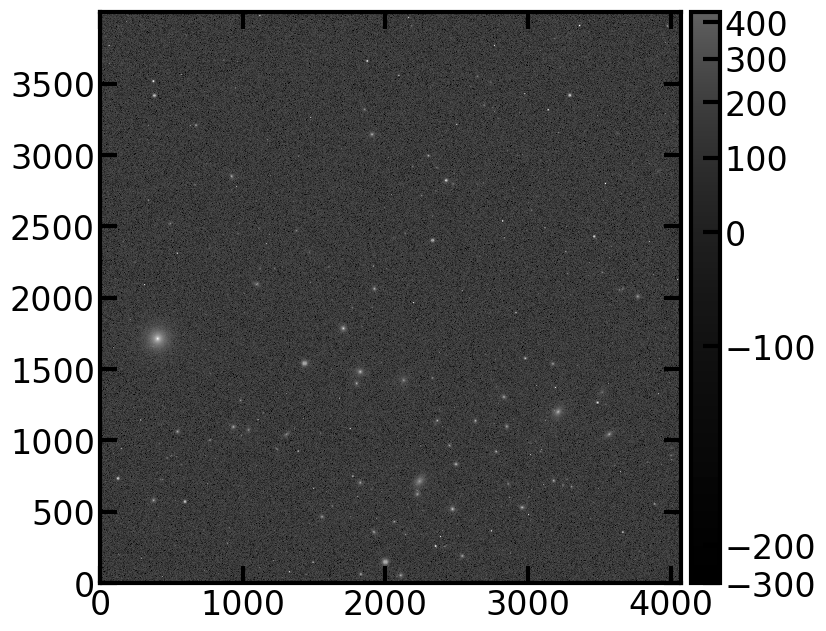

In [12]:
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image) #displays our loaded image with x and y coordinates as pixel coordinates
plt.show()
remove_figure(fig)

To see the image axes in sky coordinates instead of pixel coordinates, a simple option is to use astropy's World Coordinate System (WCS) package, along with matplotlib.pyplot's `subplot`, `imshow`, and `grid` functions. 
Recall that we imported `matplotlib.pyplot` as `plt` already, and that we imported the `astropy.wcs.WCS` constructor as simply `WCS`.
Find more information about [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) (`cmap`).

To do this, we:
1. Set the figure's projection to be the WCS of the `calexp`.
2. Define the extent in pixel coordinates using the bounding box.
3. Display the calexp image data array using the gray colormap (cmap) and use approximately the same min and max scale values as above.
4. Add solid white grid lines.
5. Label the axes, and show the plot.
6. Remove the underlying data from memory.

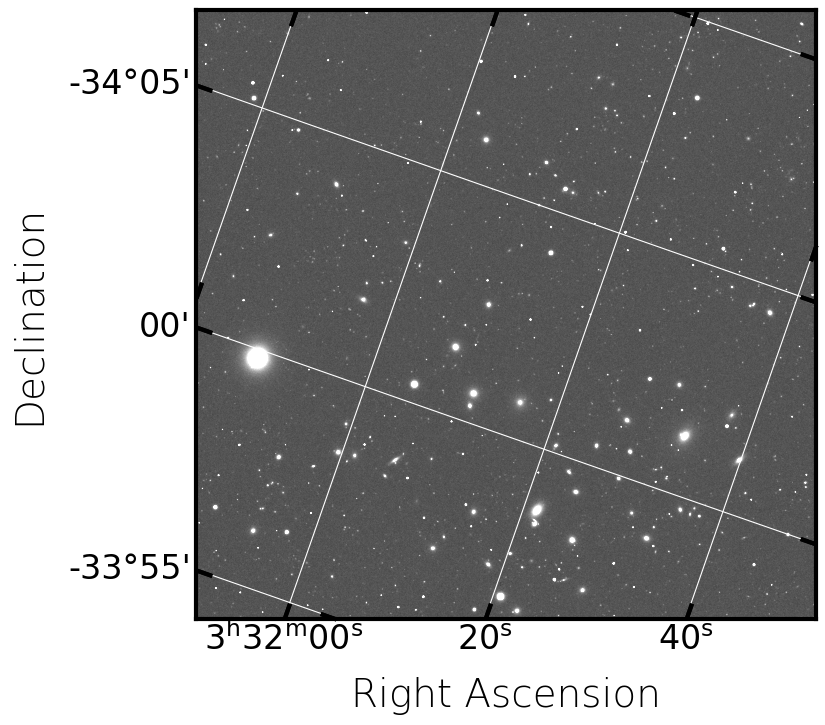

In [13]:
#does plotting with only matplotlib functions, and not any of the afwDisplay functions
fig = plt.figure()
plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
                 calexp.getBBox().beginY, calexp.getBBox().endY) #need to actually pull out the data from the calexp object now
im = plt.imshow(calexp.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=calexp_extent, origin='lower') 
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()
remove_figure(fig)

**Congratulations!** We've plotted an image in various ways using `lsst.afw.display`!

### 3.2. Use afwDisplay to visualize the image and mask plane

The `calexp` returned by the butler contains more than just the image pixel values (see the Stack Club [calexp tutorial](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb) for more details). 
One other component is the mask associated with the image. 
A mask is composed of a set of "mask planes," 2D binary bit maps corresponding to pixels that are masked for various reasons (see [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors) for more details).

The `afwDisplay` package maps each bit in the mask plane to a specific display color. 
We can view this mapping using the code in the following cell. 
We can also use the `setMaskPlaneColor` method to change the colors that `afwDisplay` uses for each mask plane.

Print the colors associated to each plane in the mask.

In [14]:
#pulling out metadata
print("Mask plane bit definitions:\n", display.getMaskPlaneColor())
print("\nMask plane methods:\n")
help(display.setMaskPlaneColor)

Mask plane bit definitions:
 {'BAD': 'red', 'CR': 'magenta', 'EDGE': 'yellow', 'INTERPOLATED': 'green', 'SATURATED': 'green', 'DETECTED': 'blue', 'DETECTED_NEGATIVE': 'cyan', 'SUSPECT': 'yellow', 'NO_DATA': 'orange', 'INTRP': 'green', 'SAT': 'green'}

Mask plane methods:

Help on method setMaskPlaneColor in module lsst.afw.display.interface:

setMaskPlaneColor(name, color=None) method of lsst.afw.display.interface.Display instance
    Request that mask plane name be displayed as color.
    
    Parameters
    ----------
    name : `str` or `dict`
        Name of mask plane or a dictionary of name -> colorName.
    color : `str`
        The name of the color to use (must be `None` if ``name`` is a
        `dict`).
    
        Colors may be specified as any X11-compliant string (e.g.
        `"orchid"`), or by one of the following constants in
        `lsst.afw.display` : `BLACK`, `WHITE`, `RED`, `BLUE`,
        `GREEN`, `CYAN`, `MAGENTA`, `YELLOW`.
    
        If the color is "ignore"

Let's plot the image and mask plane side-by-side using matplotlib subplots.

Use `plt.sca(ax[0])` to set the first axis as current, and then `plt.sca(ax[1])` to switch to the second axis.
Using `plt.tight_layout()` with multi-axis figures helps to avoid axis overlap or excessive white spaces and results in a nicer-looking plot.

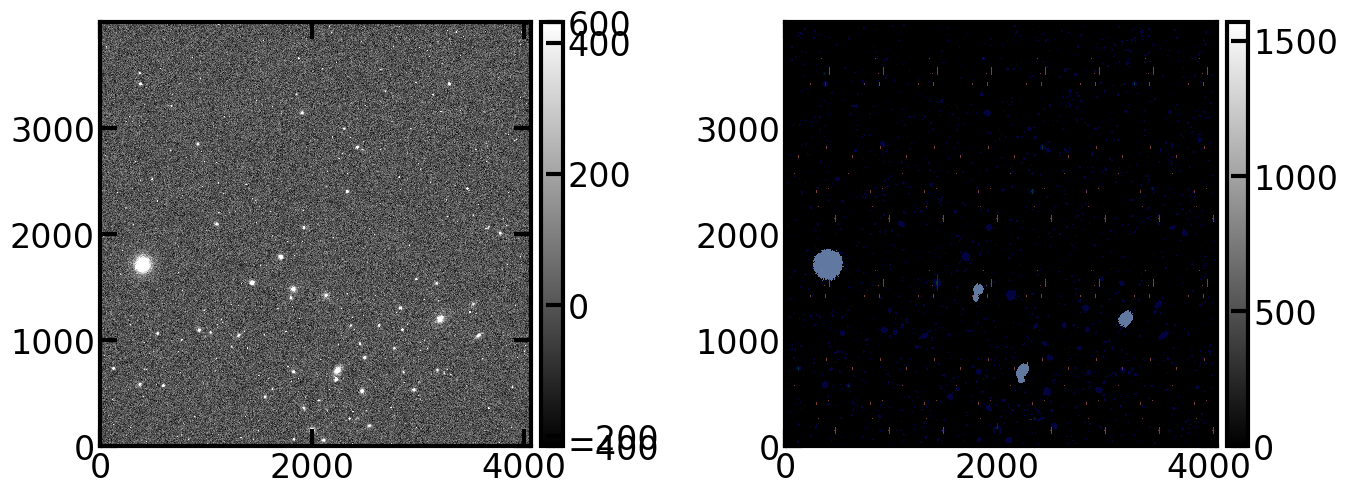

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp.image)
plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.mtv(calexp.mask)
plt.tight_layout()
plt.show()
remove_figure(fig)

The `afwDisplay` package also provides a nice interface for plotting the mask on top of the image using the `calexp.maskedImage`. 
The mask will also be plotted on top of the image if you pass the `calexp` itself to `mtv` (as is done later in this notebook).

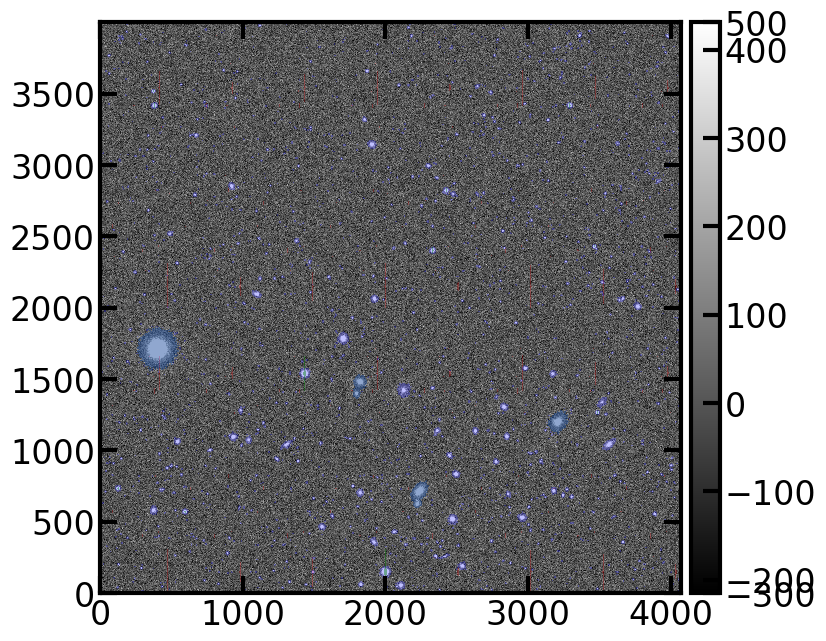

In [16]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('linear', 'zscale')
display.mtv(calexp.maskedImage)
plt.show()
remove_figure(fig)

To investigate the mask in a bit more detail, we'll follow the same steps as above to display the image, but we'll add a few modifications

1. We explicitly set the transparency of the overplotted mask
   (as a percentage: 0 = opaque, 100 = transparent)
2. We explicitly set the color of the 'DETECTED' mask plane to 'blue' (i.e., all pixels associated with detected objects).
3. We pass the full `calexp` object to `mtv` instead of just the image plane.

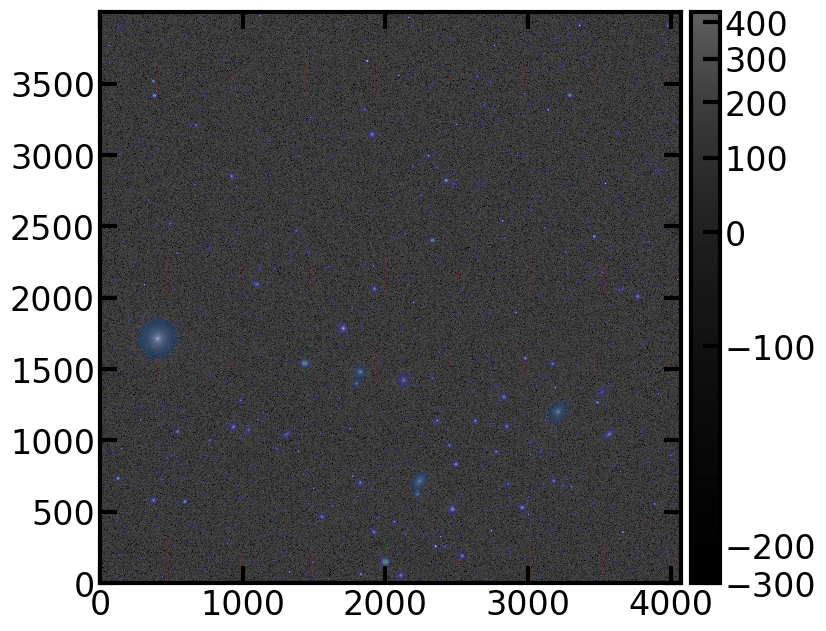

In [17]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.setMaskTransparency(80)
display.setMaskPlaneColor('DETECTED', 'blue')
display.mtv(calexp)
plt.show()
remove_figure(fig)

### 3.3. More information about `lsst.afw.display`

To find more information about `lsst.afw.display`, print the method list to see what's available. 
The next cell will print `lsst.afw.display` methods to the screen.

In [18]:
method_list = [fun for fun in dir(display) if callable(getattr(display, fun))]
print(method_list)

['Buffering', '_Buffering', '_Display__addMissingMaskPlanes', '__class__', '__del__', '__delattr__', '__dir__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'centroids', 'close', 'delAllDisplays', 'dot', 'erase', 'flush', 'getActiveCallbackKeys', 'getDefaultBackend', 'getDefaultFrame', 'getDisplay', 'getMaskPlaneColor', 'getMaskTransparency', 'image', 'incrDefaultFrame', 'interact', 'line', 'maskColorGenerator', 'mtv', 'pan', 'scale', 'setCallback', 'setDefaultBackend', 'setDefaultFrame', 'setDefaultImageColormap', 'setDefaultMaskPlaneColor', 'setDefaultMaskTransparency', 'setImageColormap', 'setMaskPlaneColor', 'setMaskTransparency', 'show', 'zoom']


If you'd like to learn more about any given function, please see the [`lsst.afw.display` source code](https://github.com/lsst/afw/tree/master/python/lsst/afw/display).

You can also read the API documentation about the above functions using the Jupyter notebook `help()` function:

In [19]:
help(display.scale)

Help on method scale in module lsst.afw.display.interface:

scale(algorithm, min, max=None, unit=None, **kwargs) method of lsst.afw.display.interface.Display instance
    Set the range of the scaling from DN in the image to the image
    display.
    
    Parameters
    ----------
    algorithm : `str`
        Desired scaling (e.g. "linear" or "asinh").
    min
        Minimum value, or "minmax" or "zscale".
    max
        Maximum value (must be `None` for minmax|zscale).
    unit
        Units for min and max (e.g. Percent, Absolute, Sigma; `None` if
        min==minmax|zscale).
    **kwargs
        Optional keyword arguments to the backend.



In [20]:
help(display.mtv)

Help on method mtv in module lsst.afw.display.interface:

mtv(data, title='', wcs=None) method of lsst.afw.display.interface.Display instance
    Display an image on a display, with semi-transparent masks
    overlaid, if available.
    
    Notes
    -----
    Historical note: the name "mtv" comes from Jim Gunn's forth imageprocessing
    system, Mirella (named after Mirella Freni); The "m" stands for Mirella.



## 4. Extract cutout images

When a closer look at images in the vicinity of a star or galaxy is needed, visualizing a small cutout instead of the full image is more effective.

### 4.1. A cutout from a `calexp`

In a science use case, the coordinates of the object of interest may be known already, but for this example choose pixels near an extended source in the image above.

In [21]:
wcs = calexp.getWcs()
radec = wcs.pixelToSky(2250, 700)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

53.09004683168595 -33.97759584632161


Use the same visit and detector as were used for the `dataId` in Section 3.

> **Notice:** In order to make a cutout of a `calexp`, the RA, Dec, visit, *and* detector must all be specified (recall that visit uniquely identifies band, so band does not need to be explicitly identified).
This is different from making a cutout with a `deepCoadd` (Section 4.2 below), which only requires RA, Dec, and band.
This is because there are multiple `calexp` images for a given coordinate and band, but only one `deepCoadd` per band.

In [22]:
visit = 192350
detector = 175

Use the `cutout_calexp` function defined in Section 1 to extract a 301x301 pixel cutout.

> **Optional:** print the help documentation for the function.

In [23]:
help(cutout_calexp)

Help on function cutout_calexp in module __main__:

cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs)
    Produce a cutout from a calexp at the given ra, dec position.
    
    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage



In [24]:
my_cutout_calexp = cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=301)

Display the cutout from the `calexp`.

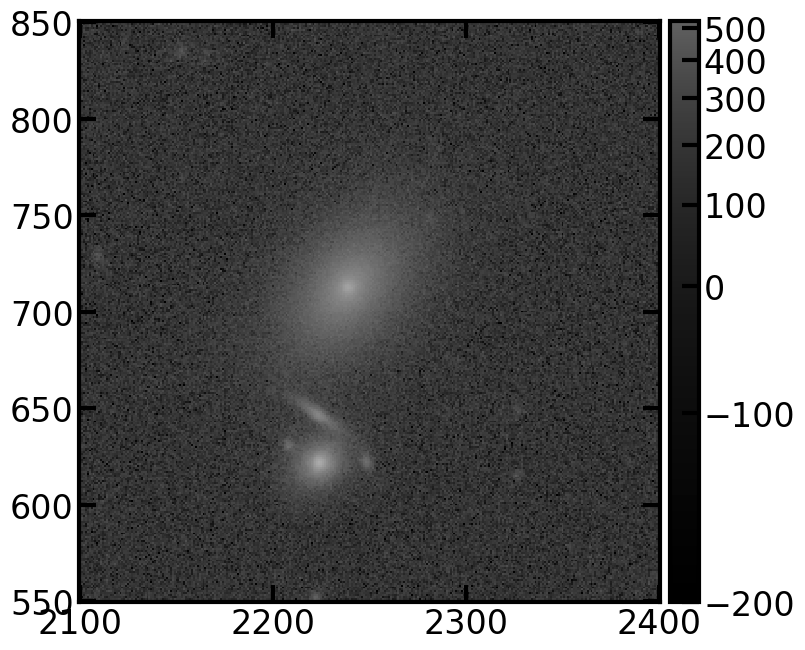

In [25]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_cutout_calexp.image)
plt.show()
remove_figure(fig)

In [26]:
del wcs, radec, ra, dec, visit, detector, my_cutout_calexp

### 4.2. A cutout from a `deepCoadd` image

Up until now, we have been examining an image from a single CCD detector taken during a single visit. For the rest of this notebook, we will switch to examining coadded images made up of multiple exposures that have been combined. 
Let's start by taking a look at what a full 4k x 4k pixel coadd "patch" image looks like. 

We start by grabbing a `deepCoadd` image and displaying it:

In [27]:
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'} #the images are divided into tracts and patches
#so you can identify a unique region of the image
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

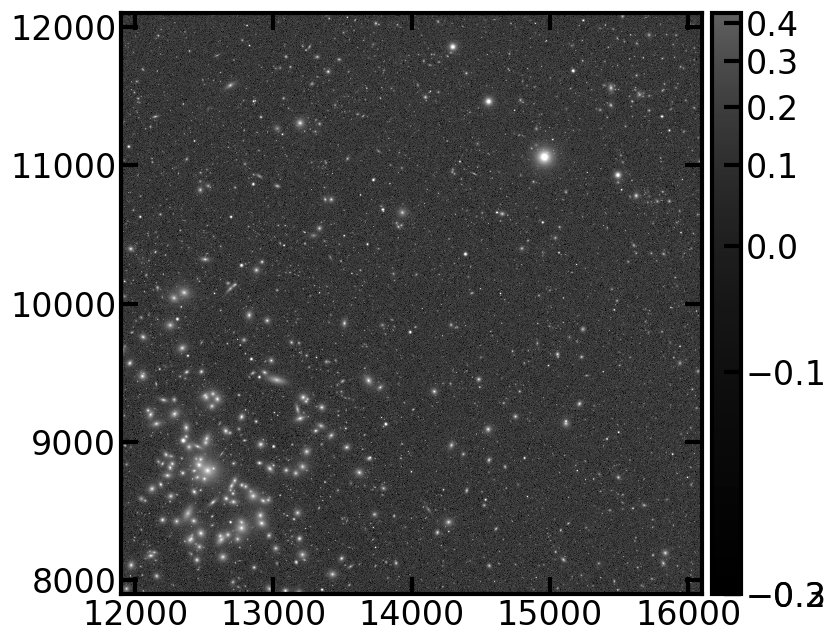

In [28]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.show()
remove_figure(fig)

Wow, check out that rich galaxy cluster in the lower-left portion of the image! 

The image above is displaying pixel coordinates (note that the coadd patch is part of a larger coadd image called a "tract", so the pixel values do not start at 0,0), but in general it is more useful to be able to select a region based on RA, Dec coordinates. To do this, we'll use the world coordinate system (WCS) object associated with the image.

Extract the WCS solution, which provides the mapping between XY pixel values and sky coordinates, and print it.

In [29]:
wcs = coadd.getWcs()
print(wcs)

FITS standard SkyWcs:
Sky Origin: (55.6521739130, -31.9834710744)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


The cluster seems to be centered at about (X, Y) ~ (12500, 8500).
Use the "pixelToSky" method of the WCS to get the sky coordinates.

In [30]:
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

55.7506834813934 -32.28892993702273


Now that we have the RA, Dec coordinates of the cluster, we would like to grab a small cutout of the coadded image at this location. To do this, we've defined a user function [`cutout_coadd` at the beginning of the notebook](#cutout_coadd). This function extracts a cutout from a deep coadd image at a given RA, Dec position and desired image size.

In [31]:
help(cutout_coadd) #describes the function we are going to use below

Help on function cutout_coadd in module __main__:

cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd', skymap=None, cutoutSideLength=51, **kwargs)
    Produce a cutout from a coadd at the given ra, dec position.
    
    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.
    
    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.
    
    Returns
    -------
    MaskedImage



We can call this function to extract a cutout image that is centered on the galaxy cluster.

In [32]:
cutout_image = cutout_coadd(butler, ra, dec, band='i', datasetType='deepCoadd',
                            cutoutSideLength=501) #sizing is in pixels
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

The size of the cutout in pixels is:  (501, 501)


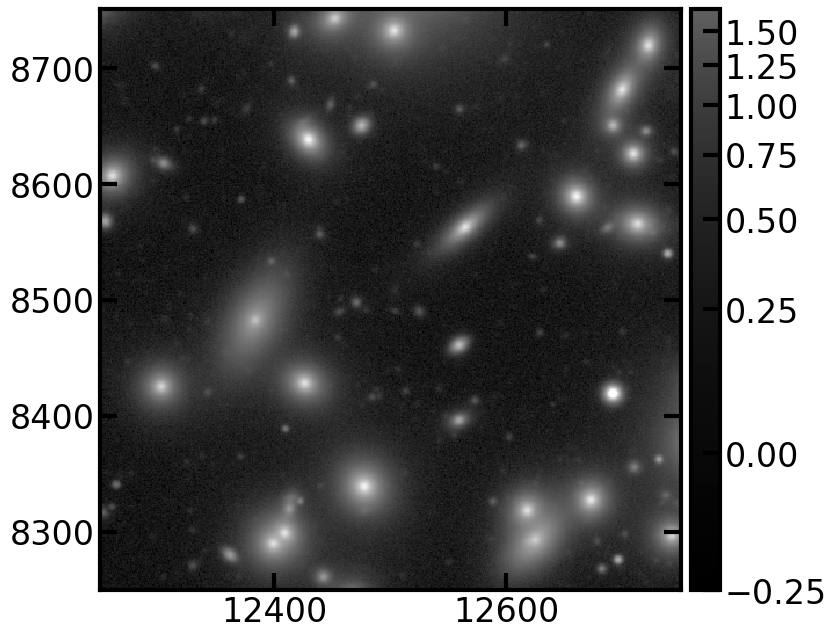

In [33]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
plt.show()
remove_figure(fig)

## 5. Overplotting catalog sources

Now that we've been able to examine the coadd image and make a cutout, we may be interested in the corresponding catalog of astronomical sources that was extracted from this image by the LSST Science Pipelines. 
The TAP service is the recommended way to retrieve catalog data for a notebook, and there are examples on how to do this in previous [tutorials](https://github.com/rubin-dp0/tutorial-notebooks).

This section demonstrates how to use TAP to retrieve the catalog data within a polygon defined by the corners of the coadd image.

The following cell extracts the XY values of the corners of the cutout image and converts them to RA, Dec, which are then used as spatial constraints in the query below.

In [34]:
wcs = cutout_image.getWcs()

x0 = float(cutout_image.getX0())
y0 = float(cutout_image.getY0())
width = cutout_image.getWidth()
height = cutout_image.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())

Instantiate the TAP service.

In [35]:
service = get_tap_service("tap")

Query for `Objects` within the bounding box corners.

> **Notice:** You may be familiar with the `BETWEEN ... AND ...` format for ADQL spatial queries, and tempted to use it here to select on RA and Dec ranges. However, the Qserv database does not know how to deal with this construction efficiently, so you are _much_ better off constructing a polygon from the corners of the image as below.

In [36]:
query = "SELECT objectId, coord_ra, coord_dec, x, y, tract, patch " + \ #will have tract and patch 
        #so we can line it up with the image later
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " +\
        "POLYGON('ICRS', " + str(ra_corners[0]) + ", " + str(dec_corners[0]) + ", " +\
        str(ra_corners[1]) + ", " + str(dec_corners[1]) + ", " +\
        str(ra_corners[2]) + ", " + str(dec_corners[2]) + ", " +\
        str(ra_corners[3]) + ", " + str(dec_corners[3]) + ")) = 1 AND " +\
        "tract = " + str(dataId['tract']) + " AND patch = " + str(dataId['patch'])
results = service.search(query)

Convert the results to an Astropy table, then take a look at the table.

In [37]:
tab = results.to_table()
tab

<Table length=214>
      objectId       coord_ra   coord_dec  ...      y       tract patch
                       deg         deg     ...     pix                 
       int64         float64     float64   ...   float64    int64 int64
------------------- ---------- ----------- ... ------------ ----- -----
1909948454470185172 55.7393808 -32.2751775 ... 8747.6994635  4431    17
1909948454470184788 55.7613844 -32.2788221 ... 8681.7890652  4431    17
1909948454470184808 55.7659405 -32.2786351 ... 8685.0823142  4431    17
1909948454470184809 55.7657282 -32.2793879 ... 8671.5347472  4431    17
1909948454470185040 55.7589613 -32.2763622 ... 8726.1058941  4431    17
1909948454470185039 55.7596823  -32.276185 ... 8729.2837482  4431    17
1909948454470184925 55.7639926 -32.2777259 ... 8701.4806726  4431    17
1909948454470183912 55.7634528 -32.2898607 ... 8483.0549053  4431    17
1909948454470183955 55.7504241 -32.2894711 ... 8490.2627299  4431    17
                ...        ...         ... ...          ...   ...   ...
1909948454470183843 55.7566696 -32.2950968 ... 8388.9072709  4431    17
1909948454470183847 55.7618874  -32.301664 ... 8270.6146066  4431    17
1909948454470183856 55.7592782 -32.3021425 ... 8262.0420477  4431    17
1909948454470183835 55.7564491 -32.2989752 ... 8319.0969352  4431    17
1909948454470183862 55.7500326 -32.3021523 ... 8261.9994808  4431    17
1909948454470183826 55.7521728 -32.2978855 ... 8338.7732188  4431    17
1909948454470183830 55.7573277 -32.3006093 ... 8289.6690366  4431    17
1909948454470183828 55.7566968 -32.3001146 ... 8298.5832257  4431    17
1909948454470204537 55.7584044 -32.2947968 ... 8394.2817721  4431    17
1909948454470204496 55.7641292 -32.3002463 ... 8296.0987745  4431    17

Display the image cutout, and use display buffering to avoid re-drawing the image after each source is plotted.

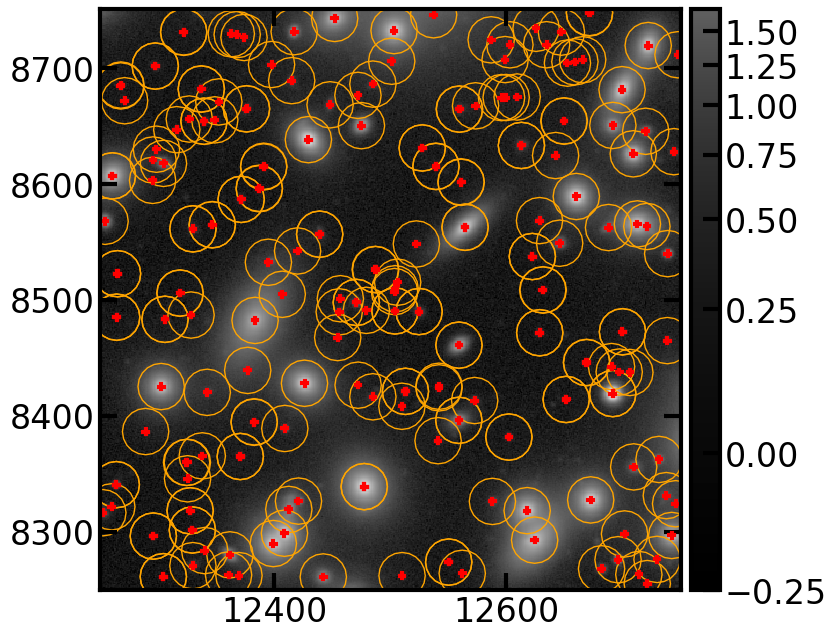

In [38]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
with display.Buffering():
    for i in range(len(tab)):
        display.dot('+', tab[i]['x'], tab[i]['y'], ctype=afwDisplay.RED)
        display.dot('o', tab[i]['x'], tab[i]['y'], size=20, ctype='orange')
plt.show()
remove_figure(fig)

Note that since the object catalog is assembled from the multi-band coadd images, not every source will necessarily be detected in our i-band image.

## 6. Plot an RGB composite image

We've found a pretty galaxy cluster, but what if we want to know about the colors of the stars and galaxies in that image? To do that, we can extract images taken with three different filters and then assign those images to the RGB channels of a color image.

We will use the `MultiBandExposure` object type from the LSST Science Pipelines `afw.image` package. 
However, one could also create a similar function that simply accepts three separate images without combining them into a MultiBand object.
Notice that the `MultibandExposure.fromExposures` function needs a list of images and filters.

In [39]:
cutout_image_g = cutout_coadd(butler, ra, dec, band='g',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_r = cutout_coadd(butler, ra, dec, band='r',
                              datasetType='deepCoadd', cutoutSideLength=701)
cutout_image_i = cutout_coadd(butler, ra, dec, band='i',
                              datasetType='deepCoadd', cutoutSideLength=701)
coadds = [cutout_image_g, cutout_image_r, cutout_image_i]
coadds = MultibandExposure.fromExposures(['g', 'r', 'i'], coadds)

Now we are ready to create the RGB (where, in case you're unfamiliar, the RGB denotes "red," "green," and "blue" channels) image. We will assign the g, r, and i-bands to the B, G, and R channels (i.e., g-band, as the bluest filter, will be in the blue channel, r-band in the green channel, and i-band as red). We will use the function [`create_rgb`](#create_rgb) that we defined at the [top of this notebook](#create_rgb).

Finally, we will plot two versions of the image to demonstrate how you can change the relative scaling of each RGB channel to produce an image that better highlights certain features. You can experiment with the "scale = []" keyword, or including different bands besides _gri_.

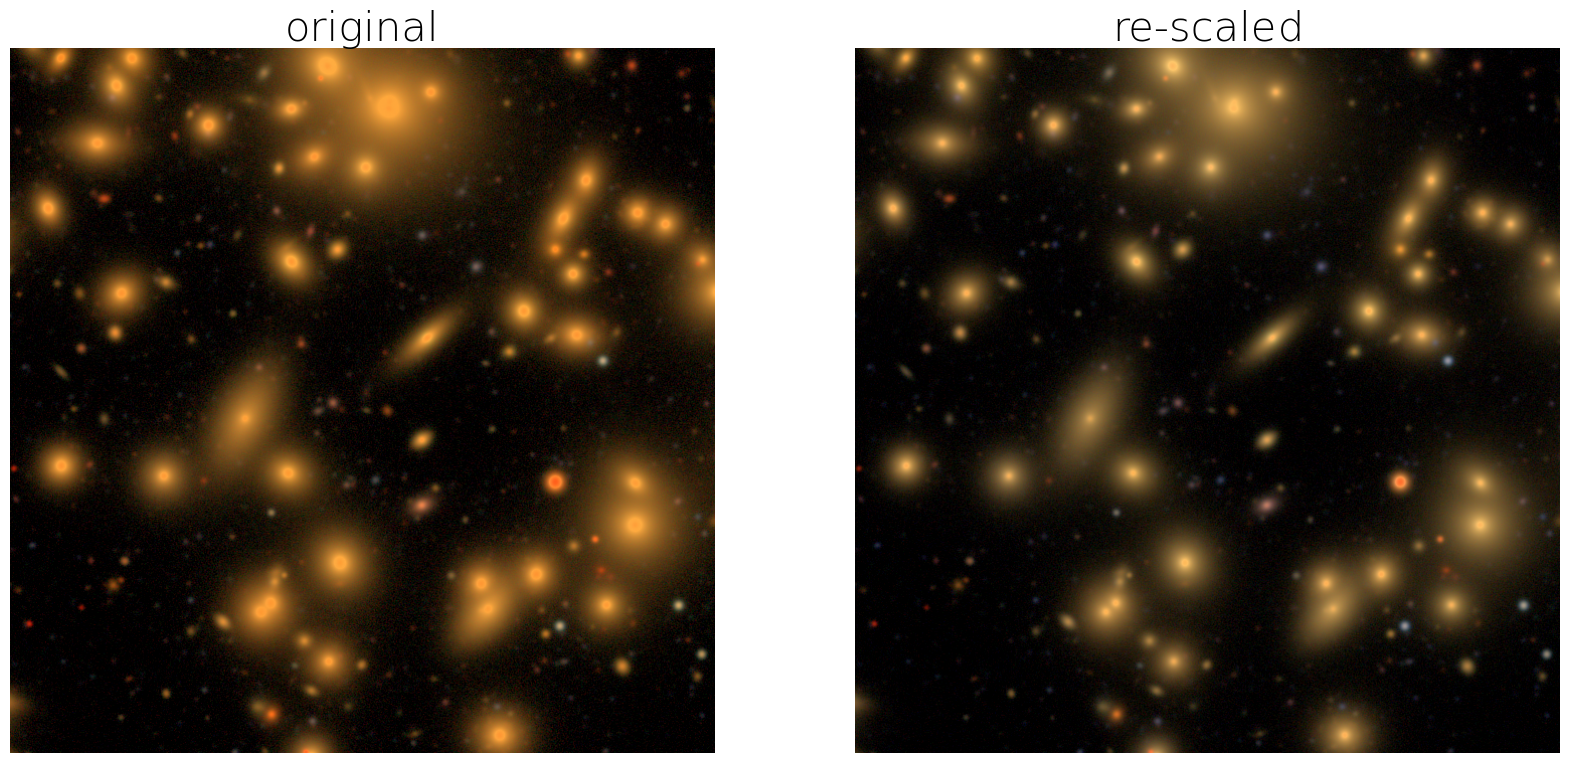

In [40]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

rgb_original = create_rgb(coadds.image, bgr=['g', 'r', 'i'], scale=None)
ax[0].imshow(rgb_original, origin='lower')
ax[0].set_title('original', fontsize=30)

ax[1].set_title('re-scaled', fontsize=30)
rgb_scaled = create_rgb(coadds.image, bgr=['g', 'r', 'i'],
                        scale=[0.6, 0.7, 1.0])
ax[1].imshow(rgb_scaled, origin='lower')

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()
remove_figure(fig)

**Congratulations** - you have now learned how to display images, create cutouts centered on a given position, and make multi-band color images. Enjoy exploring the DP0 images!

## 7. Exercises for the learner

* a) Create `coadd` and `calexp` cutouts for the same RA, Dec, and band, and compare them side-by-side.
* b) Write your own function to create a cutout of a color image.

## 8. Additional Documentation

If you'd like some more information on `lsst.afw.display`, please have a look at the following websites:

* [Info on image indexing conventions.](https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html)  
* [afw.display Doxygen website](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/namespacelsst_1_1afw_1_1display.html)  
* [afw.display GitHub website](https://github.com/RobertLuptonTheGood/afw/tree/master/python/lsst/afw/display)  
* [Getting Started on Image Display (pipelines.lsst.io)](https://pipelines.lsst.io/getting-started/display.html)